# Using Intelligence from Indeed Job postings to augment my skills.

## 1. Problem statement
I am confused on what skills are most relevant in the current job market. So after learning Ensemble learning, I loved the concept and thought of applying that idea to find my skills gap using ensemble of relevant skill data from the Indeed job posting. More like an wisdom of crowd approach. So I am aiming to find relevant skills that I should learn next before applying for my next Job to improve my odds of getting hired, and feel more confident. This is a ongoing document I use to refer back on what skills to learn and update it from time to time.

## 2. Approach
First we will download data from Indeed. I made a web scraper https://github.com/rajdeepmondal1/indeed-job-scraper that scrapes the https://in.indeed.com/ website for our essential data after searching for Data Scientist, Data Engineer, Data Science Consultant, Data Analyst and Machine Learning Engineer. Since the lines are blurry about what a Data Scientist does, we scrape data about these adjacent titles to remove bias in our data. Indeed website offers millions of searchable job listings, posted by understaffed employers. It has a built-in search engine, which allows us to filter the jobs by keyword. We will download the required information and store it in separate html files for the job listings.

Our goal is to extract common data science and machine learning skills from the downloaded data. We’ll then compare these skills to our skills to determine which skills are missing. To reach our goal, we’ll proceed like this:
 - Parse out all the text from the downloaded HTML files.
 - Explore the parsed output to learn how job skills are commonly described in online postings. Perhaps specific HTML tags are more commonly used to underscore job skills.
 - Try to filter out any irrelevant job postings from our dataset. The search engine isn’t perfect. Perhaps some irrelevant postings were erroneously downloaded. We can evaluate relevance by comparing the postings with our skill list.
 - Cluster the job skills within the relevant postings, and visualize the clusters.
 - Make a plan to improve on the skills that are missing.

In [ ]:
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
!git clone https://github.com/rajdeepmondal1/what-skills-to-augment-my-arsenal-main

Cloning into 'what-skills-to-augment-my-arsenal-main'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 15), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
data_location = '/content/what-skills-to-augment-my-arsenal-main/data/data_2161_listings.zip'

In [ ]:
unzip_data(data_location)

## 3. Dataset description
I have scraped a total of 2161 listings using https://github.com/rajdeepmondal1/indeed-job-scraper from https://in.indeed.com/ including -
 - Data Scientist with 735 listings
 - Machine Learning Engineer with 654 listings
 - Data Engineer with 317 listings
 - Data Science Consultant with 151 listings
 - Data Analyst with 304 listings
The title, company name, ratings and job description was scraped from the website for each listing.

Our rough draft of skills are stored in the skills.txt file.

We will proceed as follows:

1. Parse all text from the downloaded HTML files.
2. Explore the parsed output to learn how job skills are described in online postings. We’ll pay particular attention to whether certain HTML tags are more associated with skill descriptions.
3. Attempt to filter any irrelevant job postings from our dataset.
4. Cluster job skills based on text similarity.
5. Visualize the clusters using word clouds.
6. Adjust clustering parameters, if necessary, to improve the visualized output.
7. Compare the clustered skills to our resume to uncover missing skills.

## 4. Extracting skill requirements from job posting data

### 4.1. Loading HTML files

In [ ]:
import glob

# Evading any warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
html_contents = []

for file_name in sorted(glob.glob('/content/data_2161_listings/*/*.html')):
    with open(file_name, encoding="utf8") as f:
        html_contents.append(f.read())
        
print(f"We've loaded {len(html_contents)} HTML files.")

We've loaded 2161 HTML files.


### 4.2. Parsing HTML files

In [ ]:
# import beautiful soup
from bs4 import BeautifulSoup as bs

In [ ]:
soup_objects = []

# parse through all the html file and store it in soup objects
for html in html_contents:
    soup_objects.append(bs(html))

### 4.3. Extracting Title, Company Name and Description into their own variables.

In [ ]:
# import pandas
import pandas as pd

In [ ]:
# dictionary to store values of title, company name and description
html_dict = {
    'title': [],
    'company_name': [],
    'description': []
    }

for soup in soup_objects:
    try:
        # try to get the title using the class tag 'jobsearch-JobInfoHeader-title'
        title = soup.findAll('h1', class_='jobsearch-JobInfoHeader-title')[0].text.strip()
    except:
        title = None  
        
    try:
        # try to get the company rating using the class tag 'jobsearch-InlineCompanyRating'
        company_temp = soup.findAll('div', class_='jobsearch-InlineCompanyRating')[0]
    except:
        pass
    
    try:
        # try to get the company name
        company_name = company_temp.findAll('a')[0].text.strip()
    except:
        company_name = None
        
    # .decompose() removes a tag from the tree, then completely destroys it and its contents
    soup.findAll('h1', class_='jobsearch-JobInfoHeader-title')[0].decompose()
    soup.findAll('div', class_='jobsearch-InlineCompanyRating')[0].decompose()
    # after the decompose function removes these elements we can take the rest as description
    description = soup.text.strip()
    html_dict['title'].append(title)
    html_dict['company_name'].append(company_name)
    html_dict['description'].append(description)
    
df_jobs = pd.DataFrame(html_dict)
df_jobs[['title', 'company_name']].describe()

title company_name
count             2161         1270
unique             979          404
top     Data Scientist          IBM
freq               204           37

There are 979 Unique Job Titles with Data Scientist being the most used title with a frequency of 204 and 404 Unique Company Names with the company with the most listings being IBM with 37 listings.

### 4.4. Checking for Null Values.

In [ ]:
df_jobs['title'].isna().sum()

0

There are no null values in the title column, so we can proceed with our analysis as title is really important to analyze the job listings.

### 4.5. An Example Listing.

In [ ]:
import IPython

In [ ]:
IPython.core.display.display(IPython.core.display.HTML(html_contents[991]))

**This was a listing we extracted from the https://in.indeed.com/ website after searching for Data Scientist in India.**

The rendered job posting with a title, company name, location, brief position overview, responsibilities and quanifications. From this, we learn that the job entails surfacing insights from the data and provide strategic recommendations to better customize marketing efforts to the new region.

The skills are further elaborated in the two bolded subsections: Responsibilities, Basic Qualifications and Preferred Qualifications. Each subsection is composed of multiple single-sentence bullet points. The bullets are varied in their content but it’s worth noting that the qualifications are not that different from the responsibilities.

The qualifications focus on tools and concepts, while the responsibilities are more attuned to actions on the jobs; but in a way, their bullet points are interchangeable. Each bullet describes a skill that an applicant must have to perform well at the job. Thus, we can subdivide html_contents[0] into two conceptually different parts:

 - An initial job summary.
 - A list of bulleted skills required to get the job.

Now let us select another Random job posting to check if the Postings have a similar format.

In [ ]:
IPython.core.display.display(IPython.core.display.HTML(html_contents[777]))

This job posting is for a Staff Data Scientist position at myntra.com in Bengaluru, Karnataka. The structure is similar to the previous posting. The job is summarized in the post’s initial paragraph, and then the required skills are presented in bullet points. These bulleted skills are varied in terms of technical requirements and details.

The bullet points in listing 991 and in listing 777 serve a singular purpose: they offer us brief, sentence-length descriptions of unique skills required for each position.

We will extract the bullets from each of our parsed HTML files to find out if the bullet skill descriptions appear in other job posts.

### 4.6. Extracting bullets from the HTML

In [ ]:
# bullet.text.strip() Strips the line break from each bullet to avoid printing 
# the line breaks in our later investigations
df_jobs['Bullets'] = [[bullet.text.strip() for bullet in soup.find_all('li')] 
                      for soup in soup_objects]

The bullets in each job posting are stored in Bullets of the df_jobs dataframe. However, it is possible that some of the postings don’t include any bullets.

### 4.7. Measuring the percent of bulleted postings

In [ ]:
bulleted_post_count = 0
total_rows = df_jobs.shape[0]

# Looping over the bullets column of our dataframe
for bullet_list in df_jobs['Bullets']:
    if bullet_list:
        bulleted_post_count += 1
        
print(f"{round(100 * (bulleted_post_count / total_rows), 2)}% of the postings contain bullets")

86.12% of the postings contain bullets


To understand the contents of the bullet points we can print the top-ranked words in their text. We can rank these words by carrying out the ranking using term frequency inverse document frequency (TFIDF) values rather than raw counts. TFIDF rankings are less likely to contain irrelevant words.

Next, we rank the words using summed TFIDF values. First we compute a TFIDF matrix in which rows correspond to individual bullets. Then we sum across the rows of the matrix: these sums are used to rank the words, which correspond to matrix columns. Finally, we check the top five ranked words for skill-related terminology.

### 4.8. Examining the top-ranked words in the bullets.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def rank_words(text_list):
    """
      Returns a sorted Pandas table of top-ranked words
      args: text_list: input list of text
    """

    # initialize the tfidf vectorizer using stop words in english
    vectorizer = TfidfVectorizer(stop_words='english')

    # fit the vectorizer to the input text list and convert it to an array
    tfidf_matrix = vectorizer.fit_transform(text_list).toarray()

    # create a dataframe to store the words with their tfidf scores
    df = pd.DataFrame({'Words': vectorizer.get_feature_names(),
                       'TFIDF_scores': tfidf_matrix.sum(axis=0)})
    
    # sort the dataframe according to the tfidf scores and return it
    return df.sort_values('TFIDF_scores', ascending=False)

In [ ]:
all_bullets = []

# store all the bullets in a list
for bullet_list in df_jobs['Bullets']:
    all_bullets.extend(bullet_list)
    
# rank all the words from the bullets
sorted_df = rank_words(all_bullets)

# Print the top 5 words according to TFIDF Scores
print(sorted_df[:5].to_string(index=False))

     Words  TFIDF_scores
      data   1268.549381
experience   1114.200969
  learning    585.266786
      work    565.704799
    skills    565.142082


Words like data, experience, learning, work and skills appear among the top five bulleted words. There’s reasonable evidence that the bullets correspond to individual job skills.

Next we will check how the bulleted words compare to the remaining words in each job posting by iterating over the body of each posting and delete any bulleted lists using Beautiful Soup’s decompose method. Then we extract the remaining body text and store it in a non_bullets list. Finally, we apply our rank_words function to that list and display the top five non-bullet words.

### 4.9. Examining the top-ranked words in the the description except the bullets.

In [ ]:
non_bullets = []

# removing the bullets and keeping the rest as non-bullets
for soup in soup_objects:
    for tag in soup.body.find_all('li'):
        # .decompose() removes a tag from the tree, then completely destroys it 
        # and its contents, in this case the `li` tags
        tag.decompose()
    non_bullets.append(soup.body.text)
    
# Use the rank function defined before to rank the non bullet points
sorted_df = rank_words(non_bullets)

# Print the top 5 non-bulleted words according to TFIDF Scores
print(sorted_df[:5].to_string(index=False))

     Words  TFIDF_scores
      data    153.474594
experience     81.848449
       job     70.631671
      work     70.048442
    skills     63.047988


The non bulleted text seems to contain more of things like experiance, job, work, data and skills. These seem to be quite similar corrosponding to the bulleted materails.

Next we will check how the percentage of titles that has Data Scientist mentioned in their names.

### 4.10. Checking titles for references to data science positions.

In [ ]:
import sklearn

In [ ]:
import sklearn

def return_non_positions(regex, dataframe):
    """
      args: regex: inputs a regular expression for the role
            dataframe: inputs a dataframe
      returns: percentage of non-positions
    """
    # returns the data where the data doesnot contain the regular expression
    # and it ignores cases
    df_non_positions = dataframe[~dataframe.title.str.contains(regex, case=False)]
    return df_non_positions, round((100 * df_non_positions.shape[0] / dataframe.shape[0]), 2)

In [ ]:
regex = r'Data Scien(ce|tist)'
not_ds_position, not_data_science_percent = return_non_positions(regex, df_jobs)
print(f"{not_data_science_percent}% of the job posting titles do not mention a data science position.")

68.9% of the job posting titles do not mention a data science position.


In [ ]:
regex = r'Machine Learning (Scien|Engineer)'
not_MLE_position, not_MLE_percent = return_non_positions(regex, df_jobs)
print(f"{not_MLE_percent}% of the job posting titles do not mention a Machine Learning Engineering position.")

92.13% of the job posting titles do not mention a Machine Learning Engineering position.


In [ ]:
# Let's shuffle the df_non_ds_jobs DataFrame
df_non_ds_jobs = sklearn.utils.shuffle(not_ds_position)
df_non_ds_jobs.reset_index(inplace=True, drop=True)

print('These are the samples of such titles: - ')
for title in df_non_ds_jobs.title[:15]:
    print(title)

These are the samples of such titles: - 
Associate Data Engineer
Data Engineer
ML Engineer
Machine Learning Engineer
Front UI Engineer - Samya.ai
AI/ML Engineer
Backend Machine Learning Engineer
Data Analyst
AI Software Evangelist
Software Engineer 2 - India R&D
Computer Vision Research Engineer - Machine Learning
IoT Engineer
ML Engineer
Senior Machine Learning Engineer
Data Analyst


68.90% of the job posting titles do not mention a data science position. However, from our sampled output, we can glean the alternative language that can be used to describe a data science job. A posting may call for a Machine Learning Engineer, a AI/ML Engineer, or a Python NLP Developer.

We will Obtain relevant job postings that partially match our existing skill set and examine which bullet points in these postings are missing from our existing skill set. With this strategy in mind, we’ll now filter the jobs by relevance.

## 5. Filtering jobs by relevance

### 5.1. Loading our current skills.

In [ ]:
existing_skills = open('/content/skills.txt', 'r').read()

In [ ]:
print('Points from loaded Skills File are: - ')
print(existing_skills)

Points from loaded Skills File are: - 
Points from loaded Skills File are: - 
1. Coding For Production using Python.
2. Data Management using PostgreSQL and SQL.
3. Web Scraping using Selenium and BeautifulSoup 4.
4. Data visualization using Matplotlib and Seaborn.
5. Processing structured tables using Pandas.
6. Classification, Regression, Dimensionality Reduction, K-Means and DBSCAN clustering using Scikit-Learn.
7. Exploratory Analysis in Python and SQL.
8. NLP analysis and text topic detection using Scikit-Learn.
9. Developing probability simulations using NumPy.
10. Extreme Gradient Boosting with XGBoost. 
11. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
12. Supervised Learning and Unsupervised Learning with Scikit-Learn.
13. Machine Learning with Tree Based Models in Python.


### 5.2. Vectorizing our skills and the job-posting data.

In [ ]:
text_list = df_jobs['description'].values.tolist() + [existing_skills]
vectorizer = TfidfVectorizer(stop_words='english')
vectorized_results = vectorizer.fit_transform(text_list).toarray()

Our vectorized texts are stored in a matrix format in vectorized_results.

The final matrix row (vectorized_results[-1]) corresponds to our existing skill set, and all the other rows in (vectorized_results[:-1]) correspond to the job postings. Thus, we can easily compute the cosine similarities between the job postings and existing_skills.

We simply need to execute tfdf_matrix[:-1] @ vectorized_results[-1]: this matrix-vector product returns an array of cosine similarities.

### 5.3. Computing skill-based similarity using matrix multiplication.

In [ ]:
similarities = vectorized_results[:-1] @ vectorized_results[-1]

The similarities capture the text overlap between our existing skills and the posted jobs. Jobs with greater overlap are more relevant, and jobs with lesser overlap are less relevant. Thus, we can use cosine similarities to rank jobs by relevance.

To carry out the ranking we need to store the similarities in a Relevance column of df_jobs. Then, we sort the table by Relevance in descending order. Finally, we print the 20 least relevant job titles in the sorted table and confirm whether these low-ranking jobs have anything to do with data science.

### 5.4. Printing the 20 least relevant jobs.

In [ ]:
df_jobs['Relevance'] = similarities
sorted_df_jobs_by_relevance = df_jobs.sort_values('Relevance', ascending=False)
for title in sorted_df_jobs_by_relevance[-20:]['title']:
    print(title)

Civil Engineer Level I
Civil Engineer Level I
Consulting Engineer (Intern) - India UHR
Software Engineer Intern
Software Engineer Intern
ACN - Applied Intelligence - Solutions.AI - Data Science - 11
Analysts/Junior Consultant
Test Engineer II
Instrumentation Engineer Level I
Clinical Research ,Pharmacovigilance , CDM | Fresher
Data Analyst
Data engineer
Power BI Developer (Data Analyst)
Data Analyst
Data engineer
Data Science Manager
Data Science Manager
Artificial Intelligence / Data Science/ Machine Learning
Data Analyst
Data Analyst


### 5.5. Printing the 20 most relevant jobs.

In [ ]:
for title in sorted_df_jobs_by_relevance[:20]['title']:
    print(title)

Senior Engineer- Machine Learning (Data Scientist)
Senior Engineer- Machine Learning (Data Scientist)
Senior Engineer- Machine Learning (Data Scientist)
Lead Data Scientist
Big Data Engineer - Trainee/Fresher
Big Data Engineer - Trainee/Fresher
Big Data Engineer - Trainee/Fresher
Data Scientist (Open)
Data Scientist
Technical Trainer - Data Analysis
Data Science Lead
Data Science Lead
Senior Data Scientist
Machine Learning Engineer
Machine Learning Engineer
Data Science Engineer
Data Science Engineer
Data Science Engineer
Data Scientist
Data Scientist


Most of the jobs here relates extremely closely to a Data Science Career.

### 5.6. Plotting job ranking vs. relevance

In [ ]:
import matplotlib.pyplot as plt

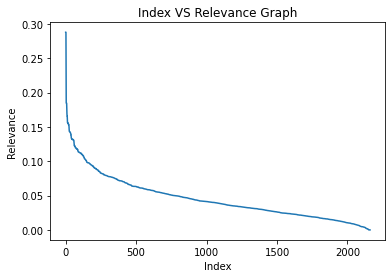

In [ ]:
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs_by_relevance['Relevance'].values)
plt.title('Index VS Relevance Graph')
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.show()

Lower indices indicate higher relevance. The relevance is equal to the cosine similarity between each job and skills. This relevance drops rapidly at an index of approximately 60.

We will include a vertical cutoff of 60 is also included in the plot. Indices below 60 correspond to much higher relevance values.

Now we will visualize the shape of the sorted relevance distribution relative to rank.

### 5.7. Adding a cutoff to the relevance plot.

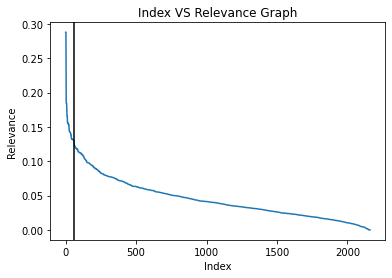

In [ ]:
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs_by_relevance['Relevance'].values)
plt.title('Index VS Relevance Graph')
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.axvline(60, c='k')
plt.show()

As we’ve already seen, the first 20 jobs are highly relevant. Based on our hypothesis, jobs 40 through 60 should be highly relevant as well. Next, we print the title of sorted_df_jobs_by_relevance[40: 60] for evaluation purposes.

In [ ]:
for title in sorted_df_jobs_by_relevance[40: 60]['title'].values:
    print(title)

AI/ML Engineer
AI/ML - Data Engineer
Data Scientist
Data Scientist
Machine Learning Architect
Machine Learning Architect
Machine Learning Architect
Machine Learning Architect
Machine Learning Architect
Machine Learning Architect
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
AI/ML Engineer (II/III)


Almost all positions are for a Data Scientist Position

In [ ]:
for title in sorted_df_jobs_by_relevance[60: 80]['title'].values:
    print(title)

Engr II AI ML Engineering
Lead Machine Learning Engineer/ Data Scientist (India)
Data Scientist
Data Science Engineer
Data Science Engineer
Data Science Engineer
Data Scientist/ Machine Learning Consultant ( UK Location)
Data Analyst
AI Engineer
Data Engineer - Remote - Indian Timezone
Data Engineer - Remote - Indian Timezone
Engineer I - Machine Learning
Engineer I - Machine Learning
Engineer I - Machine Learning
ML Engineer
Data Scientist, Machine Learning
Data Scientist, Machine Learning
Data Scientist, Machine Learning
Data Scientist, Machine Learning
Data Scientist


A few of the job titles for postings 60 through 80 are noticeably less relevant. Some jobs are for AI Engineer or Machine Learning Engineer, and few are in consulting positions. Nonetheless, a majority of the jobs refer to data science roles. We can quickly quantify this observation using regular expressions. We define a percent_relevant_titles function, which returns the percent of other related jobs in a data frame slice. Then we apply that function to sorted_df_jobs_by_relevance[60: 80]. The output gives us a very simple alternative measure of relevance based on job post titles.

### 5.8. Measuring title relevance in a subset of jobs.

In [ ]:
import re

In [ ]:
def percent_relevant_titles(df):
    regex_relevant = re.compile(r'(Data|AI|Machine Learning) (Scien|Analy|Engineer)', flags=re.IGNORECASE)
    # We ignore any management titles
    regex_irrelevant = re.compile(r'\b(Manage)', flags=re.IGNORECASE)
    match_count = len([title for title in df['title'] 
                       if regex_relevant.search(title) and not regex_irrelevant.search(title)])
    return 100 * match_count / df.shape[0]

In [ ]:
percent = percent_relevant_titles(sorted_df_jobs_by_relevance[60: 80])
print(f"Approximately {round(percent, 2)}% of job titles between indices 60 - 80 are relevant")

Approximately 55.0% of job titles between indices 60 - 80 are relevant


In [ ]:
percent = percent_relevant_titles(sorted_df_jobs_by_relevance[80: 100])
print(f"Approximately {round(percent, 2)}% of job titles between indices 80 - 100 are relevant")

Approximately 55.0% of job titles between indices 80 - 100 are relevant


In [ ]:
percent = percent_relevant_titles(sorted_df_jobs_by_relevance[100: 120])
print(f"Approximately {round(percent, 2)}% of job titles between indices 100 - 120 are relevant")

Approximately 60.0% of job titles between indices 100 - 120 are relevant


In [ ]:
percent = percent_relevant_titles(sorted_df_jobs_by_relevance[120: 140])
print(f"Approximately {round(percent, 2)}% of job titles between indices 120 - 140 are relevant")

Approximately 90.0% of job titles between indices 120 - 140 are relevant


In [ ]:
percent = percent_relevant_titles(sorted_df_jobs_by_relevance[140: 160])
print(f"Approximately {round(percent, 2)}% of job titles between indices 140 - 160 are relevant")

Approximately 55.0% of job titles between indices 140 - 160 are relevant


In [ ]:
percent = percent_relevant_titles(sorted_df_jobs_by_relevance[160: 180])
print(f"Approximately {round(percent, 2)}% of job titles between indices 160 - 180 are relevant")

Approximately 95.0% of job titles between indices 160 - 180 are relevant


In [ ]:
percent = percent_relevant_titles(sorted_df_jobs_by_relevance[180: 200])
print(f"Approximately {round(percent, 2)}% of job titles between indices 180 - 200 are relevant")

Approximately 60.0% of job titles between indices 180 - 200 are relevant


The percentages are all over the place.

So let us plot all the percentages in a graph and add a 50% relevant line to demarcate the mid center line.

### 5.9. Plotting percent relevance across all title samples.

In [ ]:
def relevant_title_plot(index_range):
    percentages = []
    for i in range(df_jobs.shape[0] - index_range):
        percentages.append(percent_relevant_titles(
            sorted_df_jobs_by_relevance[i: i + index_range])
        )
    plt.plot(range(df_jobs.shape[0] - index_range), percentages)
    plt.axhline(50, c='k')
    plt.title('Index VS Percentage of Relevant Titles')
    plt.xlabel('Index')
    plt.ylabel('% Relevant Titles')

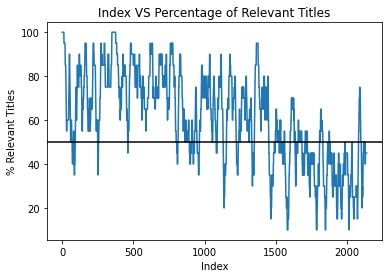

In [ ]:
relevant_title_plot(20)
plt.show()

The plot fluctuates with a high degree of variance. But despite the fluctuations, we can observe that the relevant data science titles stays at a similar level.

We can observe that with a index_range of 80 and a index cutoff of 1450, the values are quite in a decreasing slope.

### 5.10. Plotting percent relevance across an increased index range.

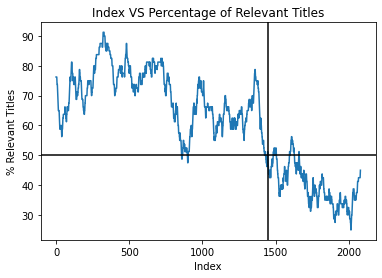

In [ ]:
relevant_title_plot(index_range=80)
plt.axvline(1450, c='k')
plt.show()

At this point, we face a choice between two relevance cutoffs. Our first cutoff, at index 80, is highly precise: most jobs below that cutoff are data science positions. However, the cutoff has limited recall: hundreds of data science jobs appear beyond an index of 80. Meanwhile, our second cutoff of 1450 captures many more data science positions, but some irrelevant jobs also appear below the cutoff range. We will incorporate both cutoffs, that way, we can compare the trade-offs and benefits of each! First, we’ll cluster the skill sets from job postings below an index of 80 then, we’ll repeat our analysis for job postings below an index of 1450. Finally, we’ll integrate these two different analyses into a single, coherent conclusion.

## 6. Clustering skills in relevant job postings

Our stated aim is to identify missing skills. The bullet points focus more on individual skills than the heterogeneous body of each posting. The short bullet points are easy to print and read. This is not the case for the larger postings. Thus, clustering by bullets allows us to examine each cluster by outputting a sample of the clustered bullet text. We’ll cluster the scraped bullets. We start by storing sorted_df_jobs[:80]['Bullets'] in a single list.

### 6.1. Obtaining bullets from the 80 most relevant jobs.

In [ ]:
total_bullets = []
for bullets in sorted_df_jobs_by_relevance[:80]['Bullets']:
    total_bullets.extend(bullets)

In [ ]:
df_bullets = pd.DataFrame({
    'Bullet': total_bullets
    })
df_bullets.describe()

Bullet
count                          1205
unique                          688
top     Temporarily due to COVID-19
freq                              9

The list contains 1,205 bullets. However, only 688 are unique - the remaining 517 bullets are duplicates. The most frequent duplicate is mentioned 9 times. If we don't deal with this issue, it could affect our clustering. We should remove all duplicate texts before proceeding with our analysis.

### 6.2. Removing duplicates and vectorizing the bullets.

In [ ]:
# remove duplicate values by taking a set of the bullets
total_bullets = sorted(set(total_bullets))

# Use TfidfVectorizer() to vectorize the bullets and 
# remove english stop words
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer to the bullets
vectorized_bullets = vectorizer.fit_transform(total_bullets)

In [ ]:
num_rows, num_columns = vectorized_bullets.shape
print(f"Our matrix has {num_rows} rows and {num_columns} columns")

Our matrix has 688 rows and 1468 columns


We've vectorized our deduplicated(data deduplication is a technique for eliminating duplicate copies of repeating data) bullet list. The resulting TFIDF matrix has 688 rows and over 1,468 columns; it thus contains over 1,009,984 elements. This matrix is too large for efficient clustering. Let's dimensionally reduce the matrix by shrinking it to 100 dimensions with SVD, and then we'll normalize the matrix.

### 6.3. Dimensionally reducing the TFIDF matrix.

In [ ]:
import numpy as np
# We use TruncatedSVD because we have a sparse matrix at hand,
# or we could have used PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

In [ ]:
np.random.seed(42)

def shrink_matrix(matrix):
    """
      Reduce dimensionality of the matrix using TruncatedSVD
    """
    svd = TruncatedSVD(n_components=100)
    return normalize(svd.fit_transform(matrix))

In [ ]:
shrunk_normal_bullets = shrink_matrix(vectorized_bullets)

### 6.4. Plotting an elbow curve using mini-batch K-means.

We use a mini batch kmeans because the dataset is large and it reduces the computational cost of finding a cluster. 

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
np.random.seed(42)

def generate_elbow_plot(matrix):
    k_values = range(1, 81)
    inertia_values = [MiniBatchKMeans(k).fit(matrix).inertia_ for k in k_values]
    plt.plot(k_values, inertia_values)
    plt.title('K VS Inertia Plot')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

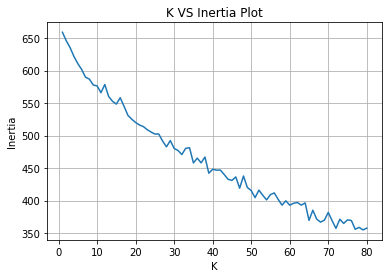

In [ ]:
generate_elbow_plot(shrunk_normal_bullets)

By seeing this graph we are not really sure what K value will be ideal, so let us try with K values from 10 to 40 with 5 in every step.

### 6.5. Grouping the job skills into 10 clusters.

In [ ]:
np.random.seed(42)

from sklearn.cluster import KMeans

def compute_clusters(shrunk_bulltes, k=10, bullets=total_bullets):
    cluster_model = KMeans(n_clusters=k)
    clusters = cluster_model.fit_predict(shrunk_bulltes)
    df = pd.DataFrame({
      'Index': range(clusters.size), 
      'Cluster': clusters, 
      'Bullet': bullets
    })
    return [bullets for _, bullets in df.groupby('Cluster')]

cluster_groups = compute_clusters(shrunk_normal_bullets)

### 6.6. Let us visualize the first cluster.

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud

np.random.seed(42)

def colors(*args, **kwargs):
  """
    Function to randomly assign one of five acceptable colors to each word
  """
  return np.random.choice(['brown', 'blue', 'teal', 'purple', 'black', 'green'])

def cluster_to_image(cluster, max_words=10, matrix=vectorized_bullets, vectorizer=vectorizer):
  """
    Converts the cluster into an wordcloud image.
    Inputs cluster, max_words, matrix and vectorizer.
      Outputs wordcloud image.
  """  
  data = {
      'Word': vectorizer.get_feature_names(),
      'tfidf_scores': np.asarray(matrix[cluster.Index.values].sum(axis=0))[0]
  }

  df_ranked_words = pd.DataFrame(data).sort_values(
      'tfidf_scores', 
      ascending=False
      )

  word_list = {
    word: score for word, score in df_ranked_words[:max_words].values if score != 0
  }

  wordcloud_generator = WordCloud(
    background_color='white', 
    color_func=colors, 
    random_state=42
  )

  return wordcloud_generator.fit_words(word_list)

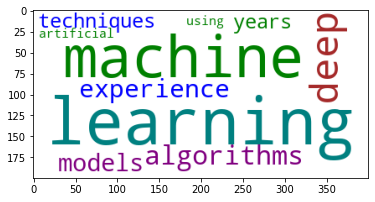

In [ ]:
wordcloud_image = cluster_to_image(cluster_groups[0], matrix=vectorized_bullets)
plt.imshow(wordcloud_image)
plt.show()

Let us see some sample bullets from this cluster.

### 6.7. Sample Bullets from the first cluster.

In [ ]:
np.random.seed(42)

def sample_cluster(c_id):
  random_bullets = np.random.choice(cluster_groups[c_id].Bullet.values, 
                                   5, 
                                   replace=False)
  for bullet in random_bullets:
    print(bullet)
        
sample_cluster(0)

Supervised machine techniques and recommendation engines
1-5 years of work or equivalent hands-on experience with design & implementation of Machine Learning models for solving business problems.
Develop machine learning applications according to requirements
Design machine learning systems
Bachelor's or Master's degree in a quantitative field (CS, machine learning, mathematics, statistics) or equivalent experience.


This cluster says about - 
1. Supervised machine techniques and recommendation engines.
2. 1–5 years of experience with the design & implementation of Machine Learning models for solving business problems.
3. Developing machine learning applications according to requirements.
4. Design machine learning systems.
5. Bachelor's or Master's degree in a quantitative field (CS, machine learning, mathematics, statistics) or equivalent experience.

### 6.8. Visualizing the 10 clusters.

In [ ]:
def plot_wordcloud_grid(clusters, num_rows=5, num_columns=2, **kwargs):
    import copy
    figure, axes = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    clusters_copy = clusters.copy()
    for row in range(num_rows):
        for column in range(num_columns):
            if not clusters_copy:
                break
            else: 
                df_cluster = clusters_copy.pop(0)
                wordcloud_image = cluster_to_image(df_cluster, **kwargs)
                ax = axes[row][column]
                ax.imshow(wordcloud_image)
                ax.set_title(f"Cluster {df_cluster.Cluster.iloc[0]}")
    plt.show()    

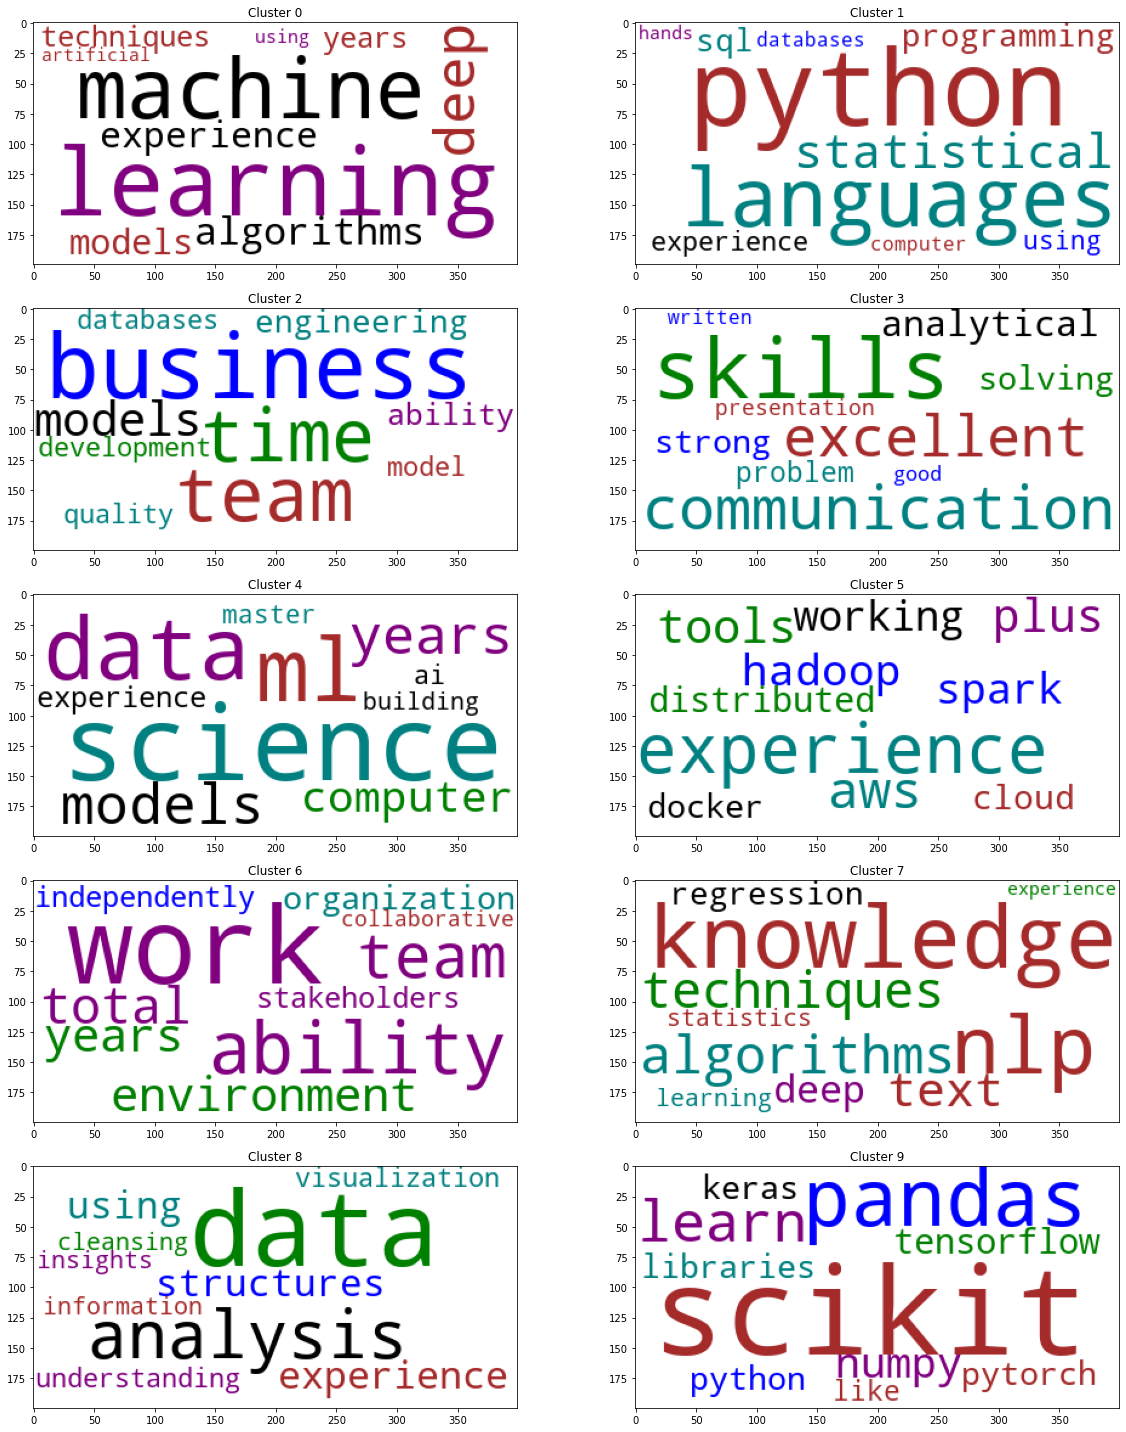

In [ ]:
plot_wordcloud_grid(cluster_groups)

Our 10 skill clusters show a diverse collection of topics. Some of the clusters are highly technical. For instance, cluster 9 fixates on external data science libraries such as scikit-learn, Pandas, NumPy, TensorFlow, Keras, and PyTorch. The scikit-learn library clearly dominates. Most of these libraries are in our skills.

Let’s print a sample of bullets from cluster 9 and confirm their focus on data science libraries.

### 6.8. Printing sample bullets from cluster 9.

In [ ]:
np.random.seed(42)

sample_cluster(9)

Understanding of ML & Data processing frameworks like TensorFlow or PyTorch, XGBoost, SciPy,
Modeling – Scikit-learn, Tensorflow, pyspark, Keras
Proficiency in either Tensorflow or Pytorch is must
Working knowledge of deep learning libraries - Keras/Tensorflow/Pytorch
Should have strong programming skills in Python in building Machine Learning models using libraries such as numpy, pandas, scikit-learn, nltk, etc.


Cluster 3 and cluster 6 talks about non technical soft skills.

### 6.9. Computing similarities between the bullets and skills.

In [ ]:
def compute_bullet_similarity(bullet_texts):
  """
    Inputs bullet texts.
    Outputs a matrix with equivalent siilarity scores.
  """
  bullet_vectorizer = TfidfVectorizer(stop_words='english')
  matrix = bullet_vectorizer.fit_transform(bullet_texts + [existing_skills])
  matrix = matrix.toarray()
  return matrix[:-1] @ matrix[-1]

bullet_similarities = compute_bullet_similarity(total_bullets)

### 6.10. Comparing mean skills similarities.

In [ ]:
def compute_mean_similarity(df_cluster):
    """
      Inputs a cluster
      Outputs the mean similarity of the bullets in the index of this cluster.
    """
    return bullet_similarities[df_cluster.Index.values].mean()
  
tech_skills_mean = compute_mean_similarity(cluster_groups[9])
soft_skills_mean = compute_mean_similarity(pd.concat([
                                                      cluster_groups[3], 
                                                      cluster_groups[6]]))

print(f"Technical cluster 9 has a mean similarity of \
{round(tech_skills_mean, 2)}")

print(f"Soft-skill cluster 3 and 6 has a mean similarity of \
{round(soft_skills_mean, 2)}")

print(f"The technical cluster is {round((tech_skills_mean/soft_skills_mean), 2)} \
times more proximate to my current technical skills.")

Technical cluster 9 has a mean similarity of 0.17
Soft-skill cluster 3 and 6 has a mean similarity of 0.02
The technical cluster is 9.49 times more proximate to my current technical skills.


Then we’ll sort the clusters by their similarity score, in descending order. If our hypothesis is correct, technical clusters will appear first in the sorted results.

### 6.11. Sorting subplots by skills similarity.

In [ ]:
def sort_clusters(clusters):
    """
      Inputs clusters.
      Returns a sorted cluster based on the cluster's mean similarity.
    """
    # compute mean silimarity of each clusters
    mean_similarities = [compute_mean_similarity(cluster) for cluster in clusters]

    # sort the indices with the key as the mean similarities
    sorted_index = sorted(range(len(clusters)), 
                            key=lambda x: mean_similarities[x], 
                            reverse=True)
    return [clusters[i] for i in sorted_index]

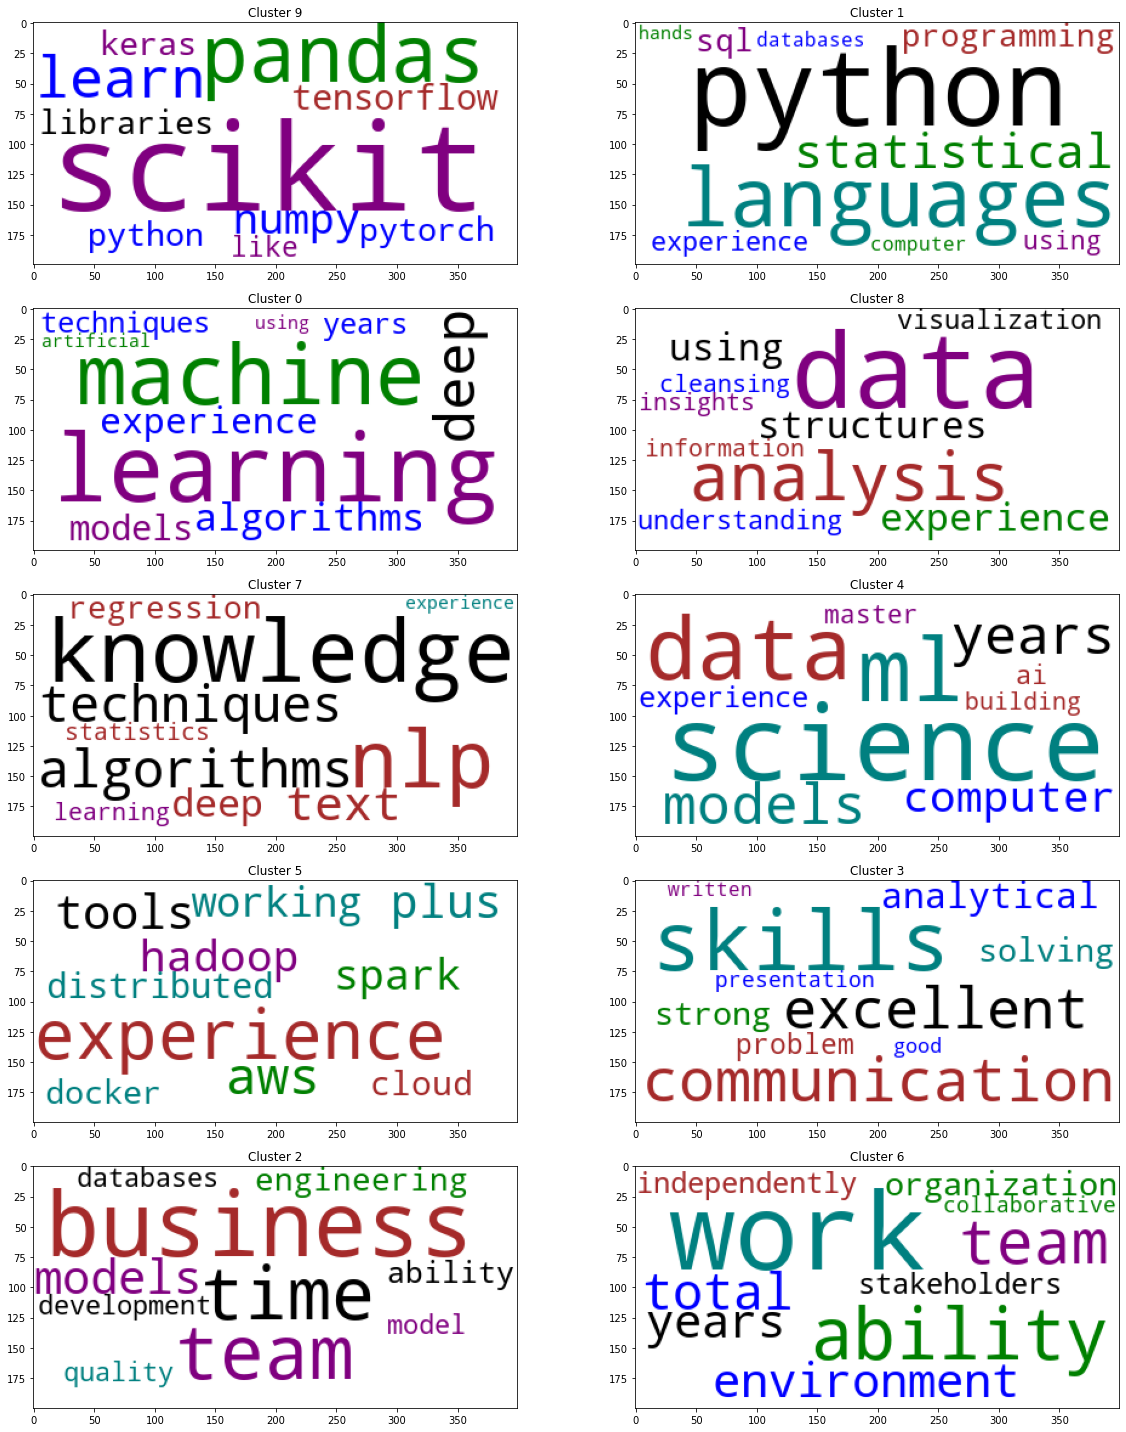

In [ ]:
sorted_clusters = sort_clusters(cluster_groups)
plot_wordcloud_grid(sorted_clusters)

Our hypothesis was right! The first two rows in the updated subplot clearly correspond to technical skills. Furthermore, these technical skills are now conveniently sorted based on their similarity to our skills. This allows us to systematically rank the skills from most similar to least similar.

### 6.12. Investigating the technical skill clusters.

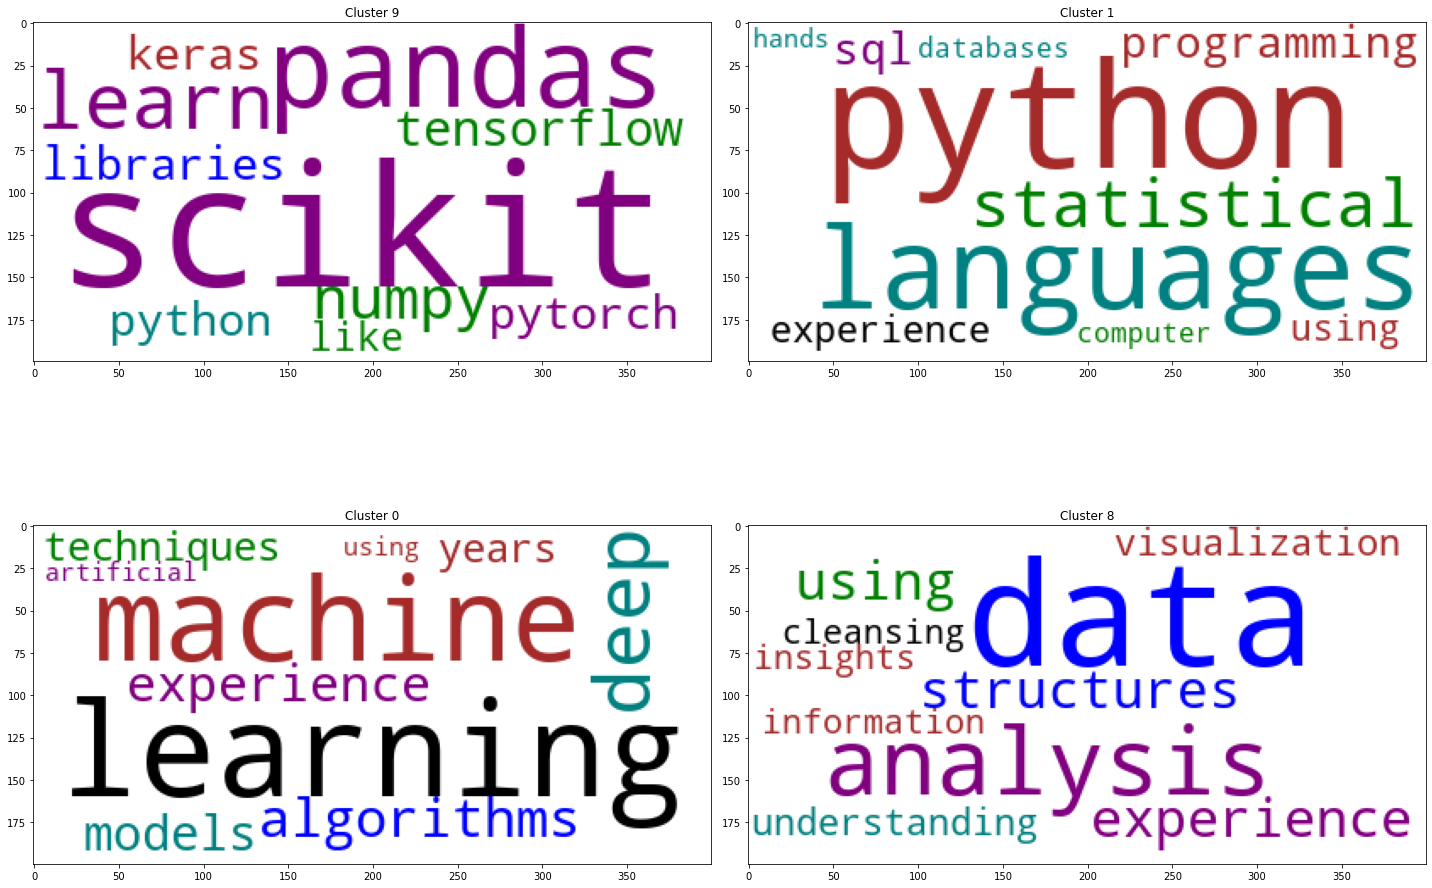

In [ ]:
plot_wordcloud_grid(sorted_clusters[:4], num_rows=2, num_columns=2)

The first few technical-skill clusters in the grid plot are very informative. We'll now examine these clusters one by one, starting with the grid's first element.
Then I will make a detailed study plan to address my skills gap.
The first four technical clusters can be described as follows:
1. Cluster 9- This data science library cluster has scikit-learn, NumPy, TensorFlow, Keras, Pytorch, and Pandas. I currently am a little bit noob in TensorFlow and Keras, which I am going to learn through the next months. 
2. Cluster 1 - This cluster focuses on Python, databases, statistics, and SQL. I am quite familiar with these. Currently, I have a basic knowledge of Statistics, so I will learn it.
3. Cluster 0 - This cluster includes having experience with Deep Learning models, Machine Learning models. The machine learning field encompasses a variety of data-driven prediction algorithms. Clustering techniques are sometimes referred to as unsupervised machine learning algorithms. Thus, a reference to unsupervised techniques is permissible. Studying the elements from the first cluster would mean that this step is covered.
4. Cluster 8 - This cluster includes skills like data cleaning, data analysis, data visualization, and understanding of information, and insights.

Study Plan for Technical skills for January 2022 to April 2022- 
Update until 30 April 2022.
1. Read [Deep Learning with Python, Second Edition](https://www.oreilly.com/videos/deep-learning-with/9781617296864AU/), by François Chollet. (Completed on 14 February 2022 except for the GAN part).
2. Complete TensorFlow Developer Certificate in 2022: Zero to Mastery (Udemy). ([Completed](https://www.udemy.com/certificate/UC-ab2e881f-97f1-4787-a73f-050701a7bfc2/) on 18 March 2022).
3. Read The Hundred Page Machine Learning Book by Andriy Burkov. (Completed on January 26, 2022).
4. Read Machine Learning Engineering by Andriy Burkov. (Completed on February 1, 2022).
5. Read [Machine Learning Design Patterns](https://www.oreilly.com/library/view/machine-learning-design/9781098115777/) by Valliappa Lakshmanan, Sara Robinson, and Michael Munn. (Completed on 21 February 2022).
6. Watch Cassie Kozyrkov's [Making friends with ML](https://www.youtube.com/playlist?list=PLRKtJ4IpxJpB_2ei8-5eWU31EZ6uSj9_s). (Completed on January 22 - 24, 2022).
7. Read [Python for Data Analysis](https://www.oreilly.com/library/view/python-for-data/9781098104023/): 3rd Edition. (Read chapters up to Advanced Pandas)
8. Read Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow by Aurelien Geron. (Read chapter 10, 11, 12, 13)
9. Complete "Machine Learning Scientist with Python Track" from Datacamp. ( [Completed](https://www.datacamp.com/statement-of-accomplishment/track/e014cfd9093f51e451f8ef2882e40046882180b5) before but revised some parts throughout).
10. Skim [SQL Cookbook](https://www.oreilly.com/library/view/sql-cookbook-2nd/9781492077435/), 2nd Edition by Anthony Molinaro, Robert de Graaf. (Read chapters 1–6)
11. [Grokking Deep Learning](https://www.oreilly.com/library/view/grokking-deep-learning/9781617293702/) by Andrew W. Trask. (Read Chapters 1, 2 - Continue)
12. Read [Data Science for Business](https://www.oreilly.com/videos/data-science-for/1449361323/): What You Need to Know about Data Mining and Data-Analytic Thinking by Foster Provost and Tom Fawcett. (Read Later)
13. Read [Practical Statistics for Data Scientists](https://www.oreilly.com/library/view/practical-statistics-for/9781492072935/): 50+ Essential Concepts Using R and Python Book by Andrew Bruce, Peter C. Bruce, and Peter Gedeck. (Skimmed for over a month).
14. Use free time to upskill using [Workera](https://workera.ai/), [__](https://app.workera.ai/public/candidate/certificate?code=ZRNXWLG9), __.

### 6.13. Investigating the soft skill clusters.

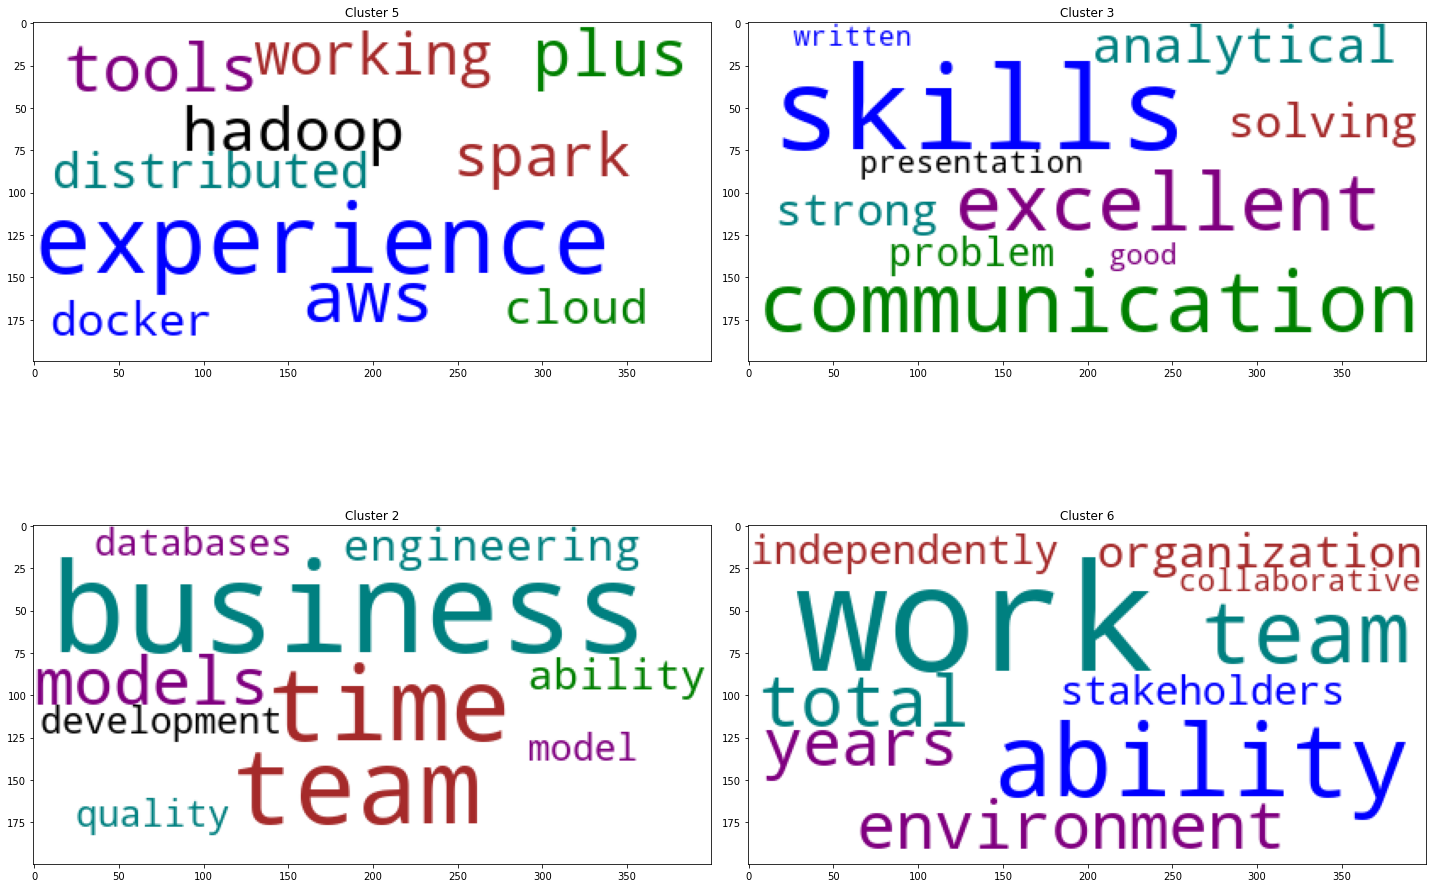

In [ ]:
plot_wordcloud_grid(sorted_clusters[6:], num_rows=2, num_columns=2)

The first four non-technical clusters can be described as follows:
1. Cluster 6 - This cluster states things like being a team player, the ability to work in a collaborative environment, and have years of experience.
2. Cluster 2 - This cluster talks about having business as well as engineering ability and deploying models within stipulated time with high quality.
3. Cluster 3- This cluster talks about having strong written communication skills, excellent analytical skills, and being a problem solver.
4. Cluster 5 - This cluster showcases experience working with Cloud technologies and distributed computing.

Study Plan - 
1. Re-Read [Influence](https://www.goodreads.com/book/show/28815.Influence) by Robert Cialdini. (Read through March)
2. Re-Read [How to win friends and Influence People](https://www.goodreads.com/book/show/4865.How_to_Win_Friends_and_Influence_People) by Dale Carnegie. (Read through January)
3. Read [Deep Work: Rules for Focused Success in a Distracted World](https://www.goodreads.com/book/show/25744928-deep-work) by Cal Newport. (Read through February)
4. Re-Read [Mindset](https://www.goodreads.com/book/show/40745.Mindset) by Carol Dweck. (Read through April)

### 6.14. Printing sample bullets from clusters 6, 2, 3 and  5.

In [ ]:
np.random.seed(42)

for cluster_id in [6, 2, 3, 5]:
    print(f'\nCluster {cluster_id}:')
    sample_cluster(cluster_id)


Cluster 6:
Work in a highly collaborative environment with other experts in Machine Learning & Data Science, Engineering, and DevOps teams.
Bachelor’s degree or one or more years of work experience.
Work from anywhere
Work along with Senior and Stake holders to capture the requirements and execute it in Agile methodology.
Comply with the terms and conditions of the employment contract, company policies and procedures, and any and all directives (such as, but not limited to, transfer and/or re-assignment to different work locations, change in teams and/or work shifts, policies in regards to flexibility of work benefits and/or work environment, alternative work arrangements, and other decisions that may arise due to the changing business environment). The Company may adopt, vary or rescind these policies and directives in its absolute discretion and without any limitation (implied or otherwise) on its ability to do so

Cluster 2:
Basic use of clouds (VM’s example EC2).
Working knowledge

## 7. Exploring clusters at alternative values of K

We got pretty descent results with K = 10, but let us try with K = 15, K = 20 and K = 25.

### 7.1. Exploring clusters with K = 15

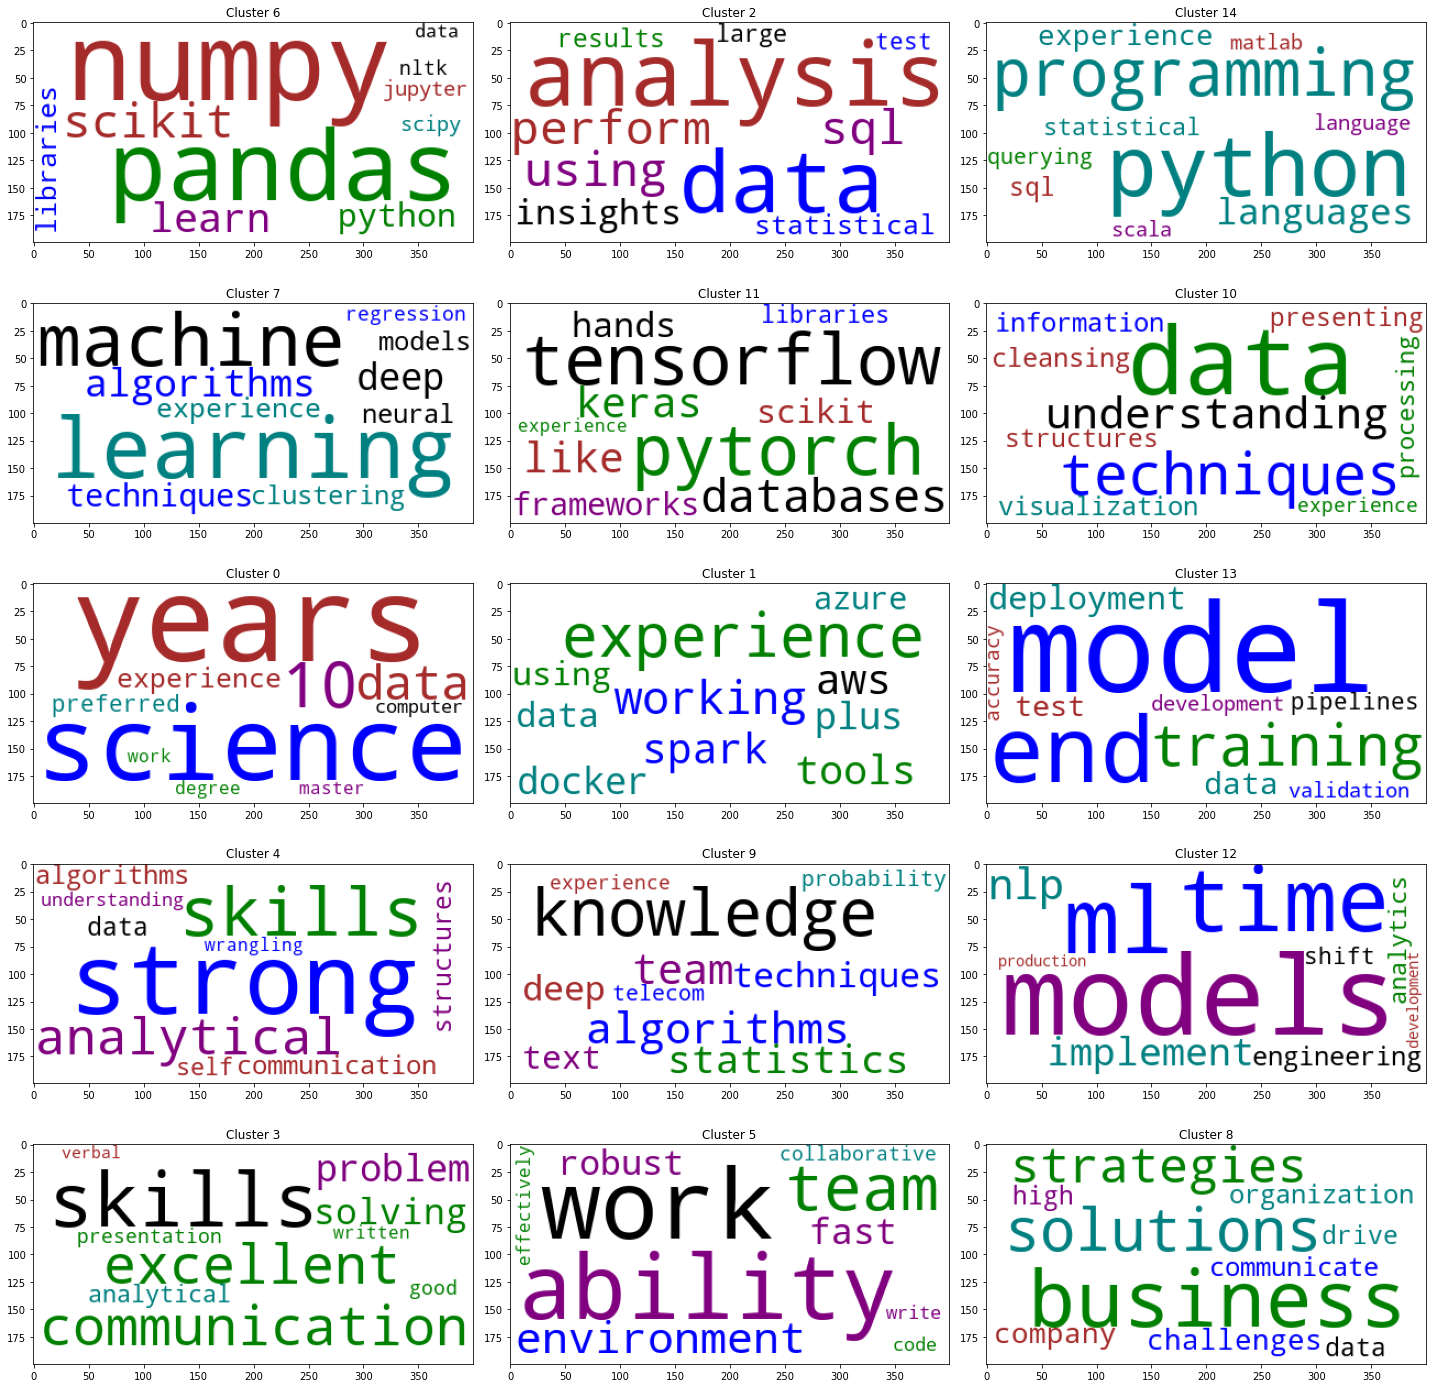

In [ ]:
np.random.seed(42)

# Compute Clusters with the normalized bullets and taking the number of clusters as 15
cluster_groups = compute_clusters(shrunk_normal_bullets, k=15)

# Sort the clusters according to mean similarity scores
sorted_cluster_groups = sort_clusters(cluster_groups)

# Plot wordcloud with the sorted clusters having 5 rows and 3 columns
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_columns=3)

### 7.2. Exploring clusters with K = 20

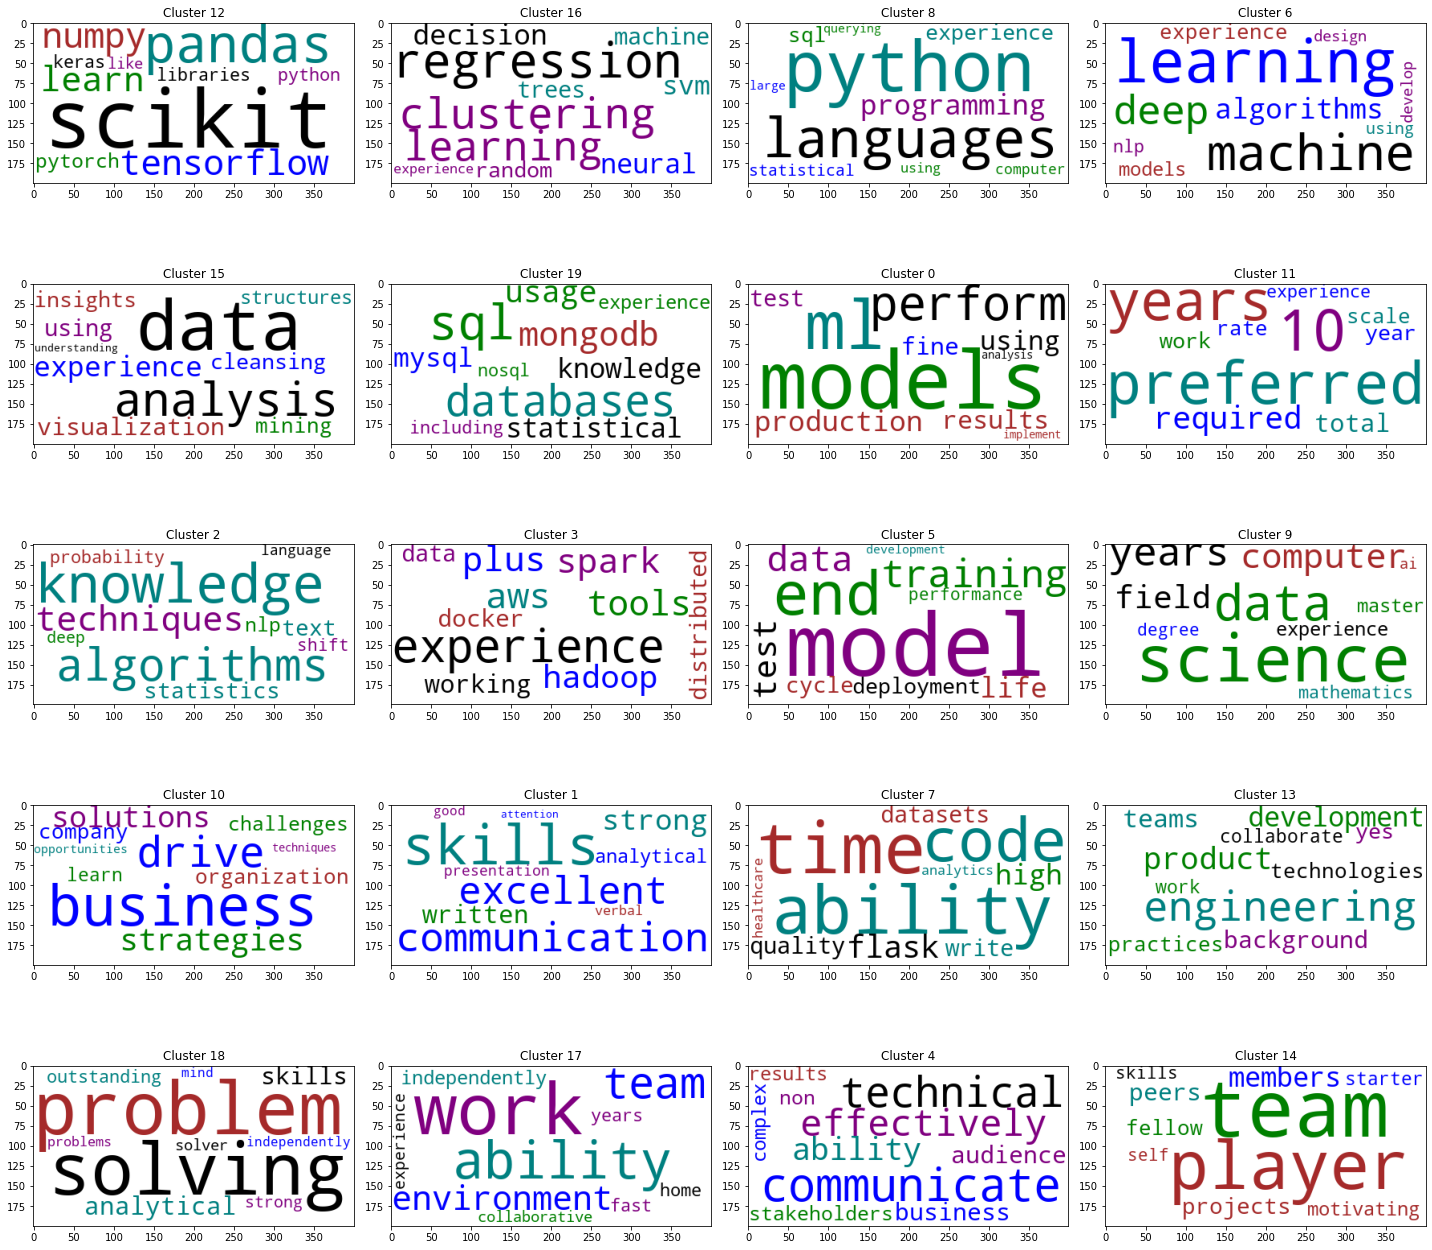

In [ ]:
np.random.seed(42)

# Compute Clusters with the normalized bullets and taking the number of clusters as 20
cluster_groups = compute_clusters(shrunk_normal_bullets, k=20)

# Sort the clusters according to mean similarity scores
sorted_cluster_groups = sort_clusters(cluster_groups)

# Plot wordcloud with the sorted clusters having 5 rows and 4 columns
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_columns=4)

### 7.3. Exploring clusters with K = 25

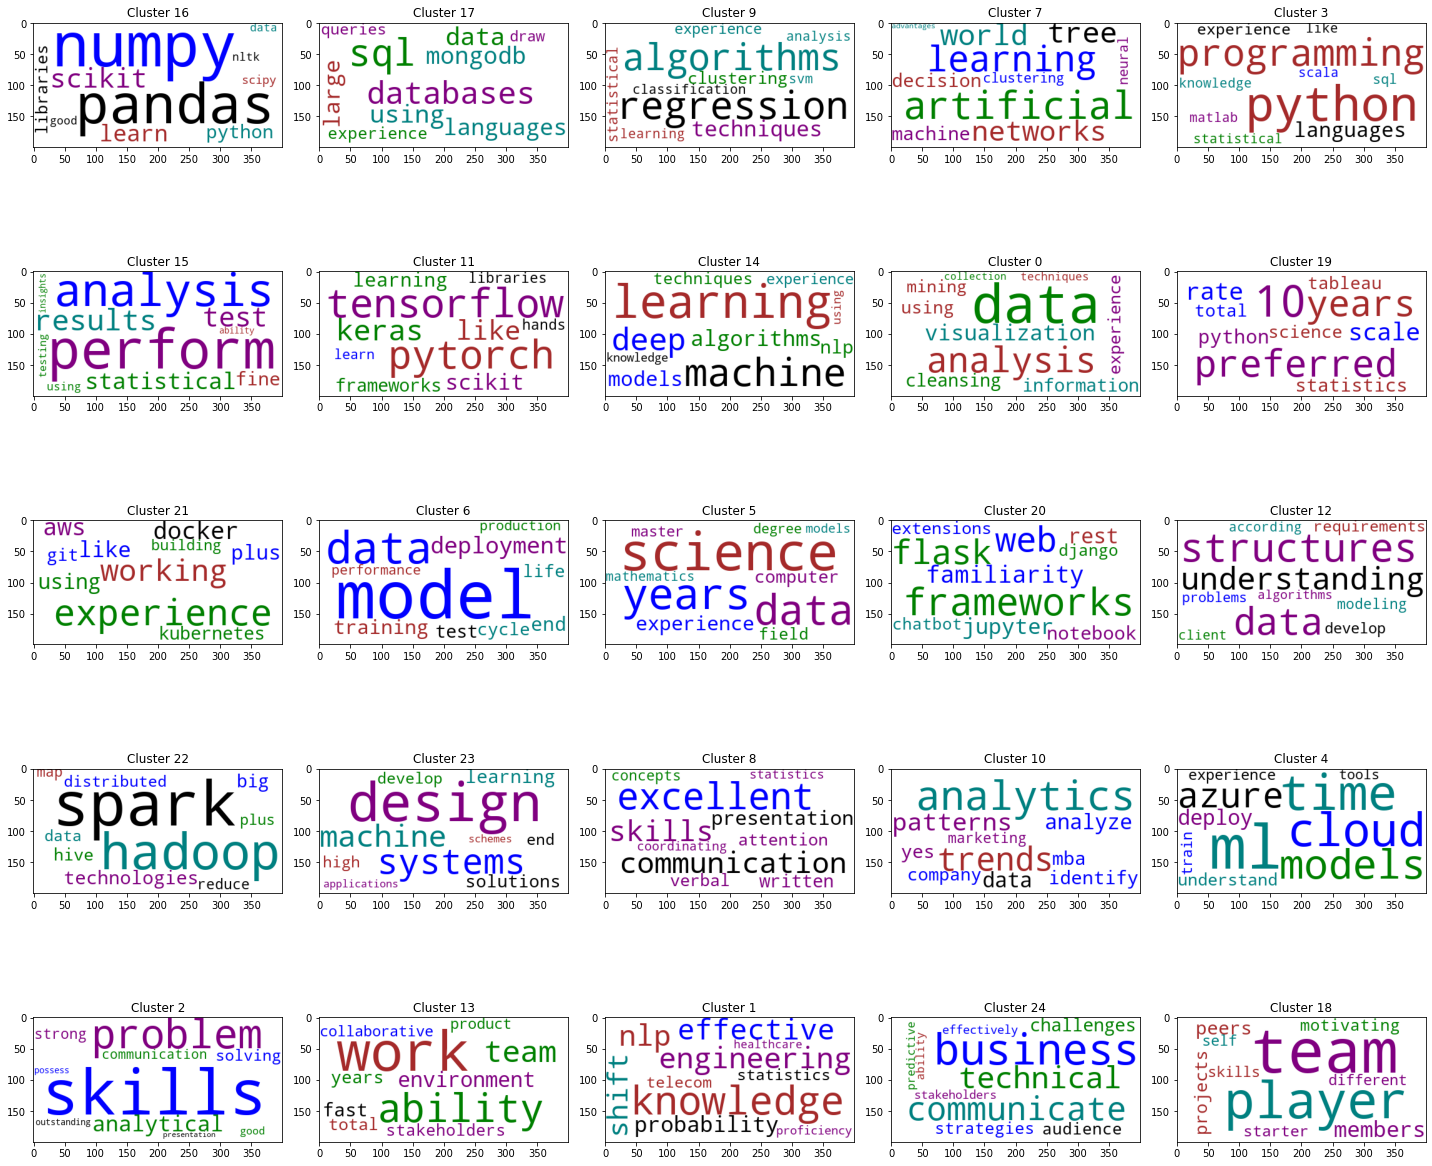

In [ ]:
np.random.seed(42)

# Compute Clusters with the normalized bullets and taking the number of clusters as 25
cluster_groups = compute_clusters(shrunk_normal_bullets, k=25)

# Sort the clusters according to mean similarity scores
sorted_cluster_groups = sort_clusters(cluster_groups)

# Plot wordcloud with the sorted clusters having 5 rows and 5 columns
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_columns=5)

Most of the skills we saw for the K = 10 are quite similar, but there were some interesting finds - 
 - Cluster 21 shows things like git, Docker, and Kubernetes.
 - Cluster 15 talks about statistical tests and analysis.
 - Cluster 23 displays things like Machine Learning System design.
 - Cluster 22 shows things like Spark, distributed training, and Hadoop.


So far, our observations have been limited to the 80 most relevant job postings. However, as we’ve seen, there is some noise in that data subset. Let us now extend our analysis to the top 1500 postings.

### 7.4. Analyzing the 1450 most relevant postings

We start by preparing sorted_df_jobs_by_relevance[:1450]['Bullets'] for clustering by doing the following:

1. Extract all the bullets while removing duplicates.
2. Vectorize the bullet texts.
3. Dimensionally reduce the vectorized texts, and normalize the resulting matrix.

In [ ]:
np.random.seed(42)

# Initialize a set to remove duplicated bullets
total_bullets_1450 = set()

# Input bullets in the set
for bullets in sorted_df_jobs_by_relevance[:1450]['Bullets']:
    total_bullets_1450.update([bullet.strip() for bullet in bullets])
    
# Sort the bullets
total_bullets_1450 = sorted(total_bullets_1450)

# Initialize a TFIDFVectorizer()
vectorizer_1450 = TfidfVectorizer(stop_words='english')

tfidf_vectorized_matrix_1450 = vectorizer_1450.fit_transform(total_bullets_1450)

# Reduce dimensionality of the bullets
normalized_bullets_1450 = shrink_matrix(tfidf_vectorized_matrix_1450)

print(f"We've vectorized {normalized_bullets_1450.shape[0]} bullets")

We've vectorized 12221 bullets


### 7.5. Plotting an elbow plot for 12,221 bullet points.

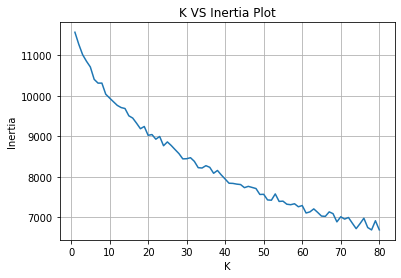

In [ ]:
np.random.seed(42)
generate_elbow_plot(normalized_bullets_1450)

The precise location of the elbow is not clear in the plot. The elbow is spread out between a K of 10 and 30. We’ll deal with ambiguity by arbitrarily setting K to 20.

### 7.6. Visualizing 20 clusters for 12,522 bullet points.

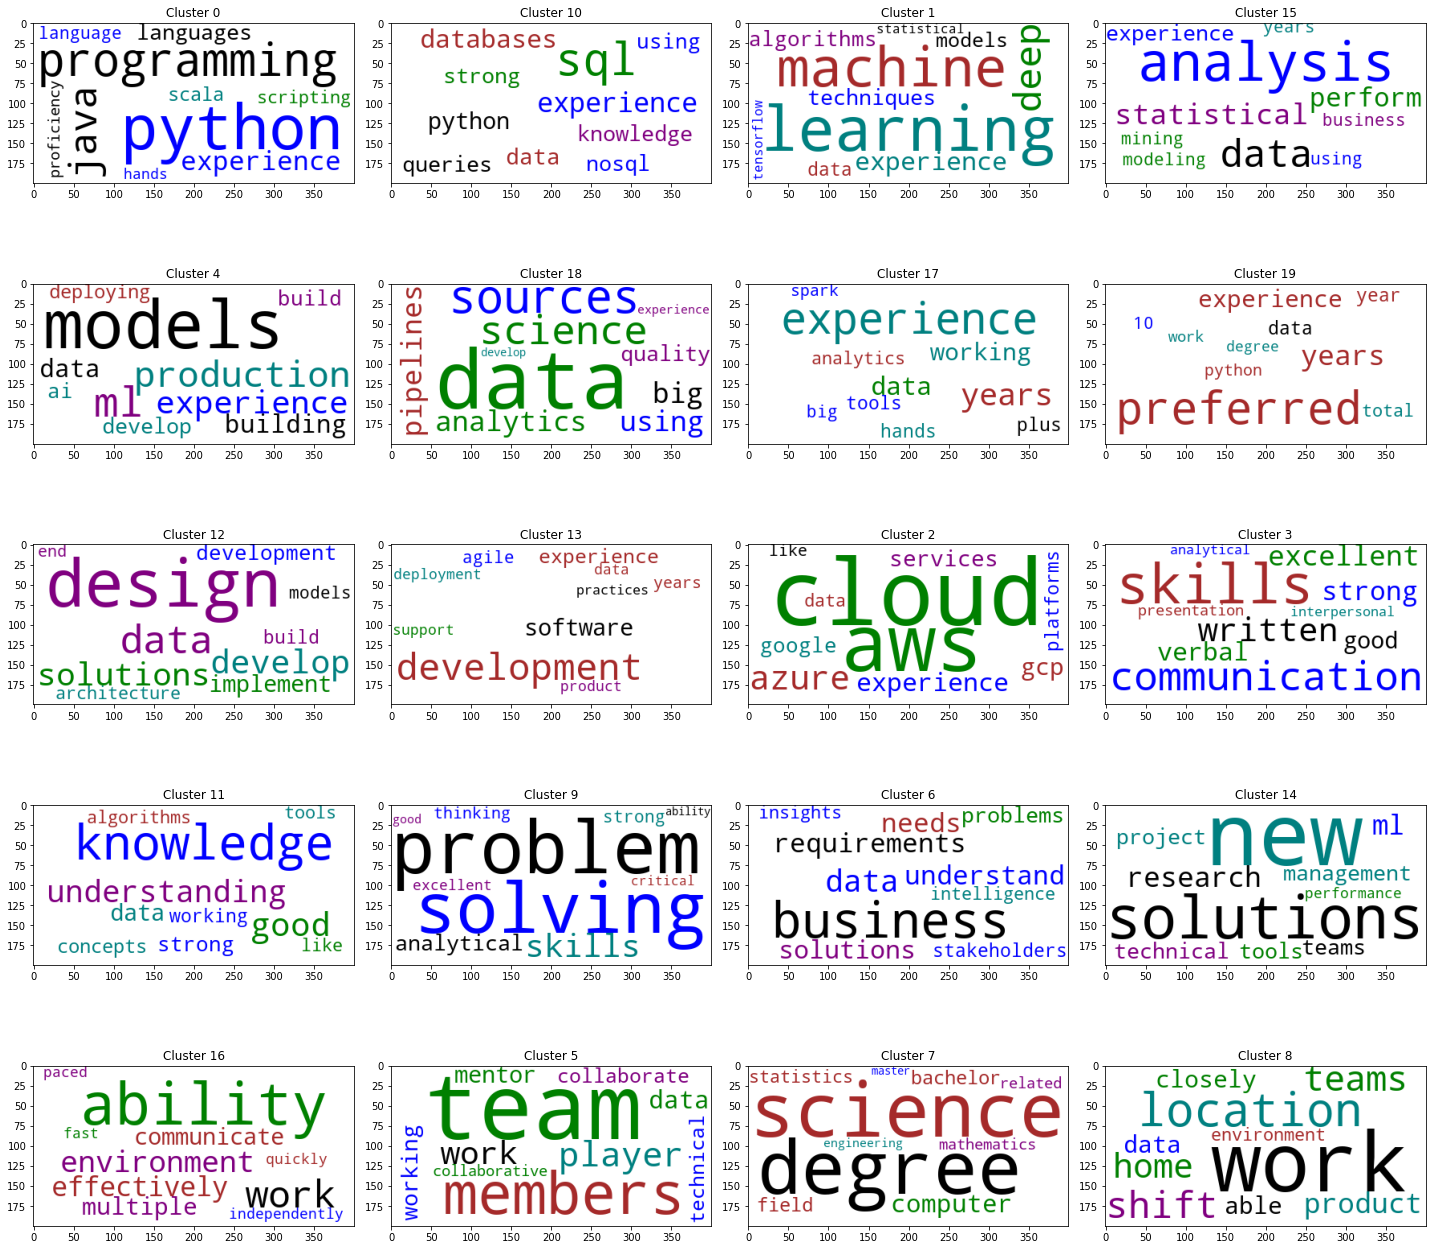

In [ ]:
np.random.seed(42)

# create 20 clusters with the normalized bullets
cluster_groups_1450 = compute_clusters(normalized_bullets_1450, 
                                       k=20, 
                                       bullets=total_bullets_1450)

# Compute the similarity between the bullets
bullet_similarities = compute_bullet_similarity(total_bullets_1450)

# Sort the clusters according to mean similarity scores
sorted_cluster_groups = sort_clusters(cluster_groups_1450)

# Plot wordcloud from the sorted cluster
plot_wordcloud_grid(sorted_cluster_groups, 
                    num_rows=5, 
                    num_columns=4,
                    vectorizer=vectorizer_1450,
                    matrix=tfidf_vectorized_matrix_1450)

This list of word clouds is the culmination of 1450 listings, lets's see what something new we could find here - 
1. Cluster 0 displays the programming languages required like Python, Java, or Scala.
2. Cluster 10 tells about the strong knowledge required with SQL and NoSQL databases.
3. Cluster 19 tells about the preferred experience for getting hired.
4. Cluster 2 displays cloud technologies like AWS, Azure, and GCP.
5. Cluster 7 refers to the background of the candidates with a minimum Bachelor's degree in Computer Science, Mathematics, statistics, and Engineering.
6. Cluster 16 states qualities like the ability to communicate effectively, and work independently in a fast-paced environment.

# Conclusion - 
I will continue to augment my skills with this newfound knowledge, mainly focusing on good communication skills where I lack the most. Hopefully, we both learned something from this, and wish you all the best in your journey of learning and growing.

Wish you all the best. I am really grateful to you for reading through this enormous report. I learned and enjoyed every moment of making this. Until we meet again, stay fantastic.